In [4]:
%%bash
pip install gensim
pip install emoji --no-deps
pip install stopwordsiso

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 48.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.1 MB/s eta 0:00:00


## Import Libraries

In [5]:
import re
import string
import emoji
import pandas as pd
import nltk
import stopwordsiso
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
from stopwordsiso import stopwords
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn import svm
import pickle
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
import torch
from transformers import BertModel, BertTokenizer
import gc
from transformers import (
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel
)

from sklearn.model_selection import train_test_split
import re
import os
import requests
import gc
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read Data

In [6]:
train = pd.read_csv('/kaggle/input/german-hasoc19/german_dataset.tsv', sep='\t')
test = pd.read_csv('/kaggle/input/german-hasoc19/hasoc_de_test_gold.tsv', sep='\t')

train.drop(["text_id", 'task_2'], axis=1, inplace=True)
test.drop(["text_id", 'task_2'], axis=1, inplace=True)

# rename task_1 to label
train.rename(columns={'task_1': 'label'}, inplace=True)
test.rename(columns={'task_1': 'label'}, inplace=True)

# Map the labels to integers
label_map = {'HOF': 1, 'NOT': 0}

train['label'] = train['label'].map(label_map)
test['label'] = test['label'].map(label_map)

In [7]:
train.shape, test.shape

((3819, 2), (850, 2))

## Data Pre-processing

In [8]:
import pandas as pd
import string
import emoji

def preprocess_german_text(df):
    """
    Preprocess German text data in the 'text' column by:
    - Removing mentions (@USERS)
    - Removing hashtags
    - Removing URLs
    - Removing punctuation
    - Collapsing multiple spaces
    - Converting text to lowercase
    - Replacing umlauts with equivalent character combinations
    - Expanding common abbreviations
    - Removing German stopwords
    
    Parameters:
        df (pd.DataFrame): The dataset containing the 'text' column.
        
    Returns:
        pd.DataFrame: The processed dataset with the 'text' column cleaned.
    """
    # Removing @USER mentions
    df['text'] = df['text'].str.replace(r'@\w+\s*', '', regex=True)
    
    # Removing hashtags
    df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)
    
    # Removing URLs
    df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    
    # Replacing punctuation with space
    df['text'] = df['text'].str.replace(f"[{string.punctuation}]", ' ', regex=True)
    
    # Removing digits
    df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
    
    # Removing extra spaces
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # Converting text to lowercase
    df['text'] = df['text'].str.lower()
    
    return df

def process_text_with_emojis(text):
    """
    Replace emojis with descriptive text and handle demojized content.
    """
    text_without_emojis = emoji.demojize(text)
    return text_without_emojis

In [9]:
# Apply preprocessing functions to the train and test datasets
train = preprocess_german_text(train)
test = preprocess_german_text(test)

# Replace emojis with text
train["text"] = train["text"].apply(process_text_with_emojis)
test["text"] = test["text"].apply(process_text_with_emojis)

In [10]:
# Load German stopwords
if stopwordsiso.has_lang("de"):  # Check if stopwords exist for German
    german_stopwords = stopwords("de")

def remove_stopwords(text):
    """
    Remove German stopwords from text.
    """
    words = text.split()
    filtered_words = [word for word in words if word not in german_stopwords]
    return ' '.join(filtered_words)

# Remove German stopwords
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

# Handle compound words (optional; split long words if necessary)
def split_compound_words(sentence):
    """
    Add spaces between words in German compound words, if needed (custom implementation).
    This can be improved with specific tools for compound splitting.
    """
    # Example heuristic: split words longer than 20 characters
    words = sentence.split()
    processed_words = [re.sub(r'([a-zA-Z]{10,})', r'\1 ', word) if len(word) > 20 else word for word in words]
    return ' '.join(processed_words)

train['text'] = train['text'].apply(split_compound_words)
test['text'] = test['text'].apply(split_compound_words)

# Replace multiple consecutive spaces
train['text'] = train['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
test['text'] = test['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [11]:
# remove rows with empty text
train = train[train['text'] != '']
test = test[test['text'] != '']

In [12]:
train.head()

,text,label
0,frank rennicke – stolz,0
1,ansehen bitte teilen teilen teilen,0
2,mohamed erkennt deutsches kölner dom kaputt sc...,0
3,brutale islamische diktatur richtete kürzlich ...,0
4,bundespolizei quartal illegale einreisen regis...,0


In [13]:
test.head()

,text,label
0,grüne intelligenz bestie eckhardt prangert tic...,1
1,deutschlandlied sinn unsinn,0
3,esc kandidatinnen schuld point public junge fr...,1
4,scheinbar bekommt sarah conner sohn vincent mä...,1
5,überzeugen politische linke frau gleichberecht...,1


## LSTM

In [14]:
# Parameters
MAX_LEN = 300
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = 2

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-german-cased")

def tokenize_texts(texts):
    return [torch.tensor(tokenizer.encode(text, truncation=True, max_length=MAX_LEN)) for text in texts]

# Prepare datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(train['text'], train['label'], test_size=0.2, random_state=42, stratify=train['label'])
test_texts, test_labels = test['text'], test['label']

train_tokens = tokenize_texts(train_texts)
val_tokens = tokenize_texts(val_texts)
test_tokens = tokenize_texts(test_texts)

# Label encoding
label_encoder = LabelEncoder()
train_labels = torch.tensor(label_encoder.fit_transform(train_labels))
val_labels = torch.tensor(label_encoder.transform(val_labels))
test_labels = torch.tensor(label_encoder.transform(test_labels))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

In [15]:
# Dataset Class
class TextDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokens[idx], self.labels[idx]

# Padding function
def collate_fn(batch):
    tokens, labels = zip(*batch)
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=tokenizer.pad_token_id)
    return tokens_padded, torch.tensor(labels)

# DataLoader
train_dataset = TextDataset(train_tokens, train_labels)
val_dataset = TextDataset(val_tokens, val_labels)
test_dataset = TextDataset(test_tokens, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [16]:
# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return self.softmax(output)

# Initialize model
VOCAB_SIZE = tokenizer.vocab_size
model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
# Training Loop
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss, total_correct = 0, 0

    for tokens, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(data_loader), total_correct / len(train_loader.dataset)

In [18]:
# Evaluation Function
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for tokens, labels in data_loader:
            outputs = model(tokens)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

            predictions.extend(outputs.argmax(1).tolist())
            true_labels.extend(labels.tolist())

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset), predictions, true_labels

In [19]:
# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.4318, Train Accuracy: 0.8915
Val Loss: 0.4239, Val Accuracy: 0.8916
Epoch 2/10
Train Loss: 0.4219, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916
Epoch 3/10
Train Loss: 0.4227, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916
Epoch 4/10
Train Loss: 0.4227, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916
Epoch 5/10
Train Loss: 0.4218, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916
Epoch 6/10
Train Loss: 0.4218, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916
Epoch 7/10
Train Loss: 0.4227, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916
Epoch 8/10
Train Loss: 0.4218, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916
Epoch 9/10
Train Loss: 0.4210, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916
Epoch 10/10
Train Loss: 0.4210, Train Accuracy: 0.8915
Val Loss: 0.4237, Val Accuracy: 0.8916


Test Loss: 0.4833, Test Accuracy: 0.8300
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       664
           1       0.00      0.00      0.00       136

    accuracy                           0.83       800
   macro avg       0.41      0.50      0.45       800
weighted avg       0.69      0.83      0.75       800



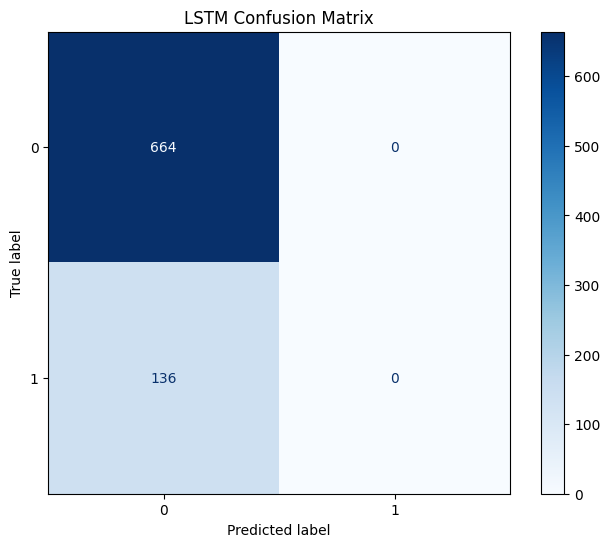

In [20]:
# Test Evaluation
test_loss, test_acc, test_preds, test_true = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Classification Report
class_names = [str(cls) for cls in label_encoder.classes_]  # Convert classes to strings
print(classification_report(test_true, test_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)

# Plot the confusion matrix with blue color
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("LSTM Confusion Matrix")
plt.show()

## LLM-Based Approach

### BERT

In [21]:
# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train['text'].tolist(), train['label'].tolist(), test_size=0.2, random_state=42, 
    stratify = train['label']
)

test_texts = test['text'].tolist()
test_labels = test['label'].tolist()

In [22]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 4. Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

# Training
trainer.train()

# Save Model
model.save_pretrained('./hate_speech_model')
tokenizer.save_pretrained('./hate_speech_model')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.329100,0.339087,0.891566,0.000000,0.000000,0.000000
2,0.337400,0.333225,0.891566,0.000000,0.000000,0.000000
3,0.309900,0.303662,0.890228,0.473684,0.111111,0.180000


{'eval_loss': 0.3036624491214752, 'eval_accuracy': 0.8902275769745649, 'eval_precision': 0.47368421052631576, 'eval_recall': 0.1111111111111111, 'eval_f1': 0.18, 'eval_runtime': 3.251, 'eval_samples_per_second': 229.775, 'eval_steps_per_second': 1.846, 'epoch': 3.0}


Test Results: {'eval_loss': 0.44142937660217285, 'eval_accuracy': 0.83125, 'eval_precision': 0.5555555555555556, 'eval_recall': 0.03676470588235294, 'eval_f1': 0.06896551724137931, 'eval_runtime': 3.4509, 'eval_samples_per_second': 231.822, 'eval_steps_per_second': 2.028, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.83      0.99      0.91       664
    Hate Speech       0.56      0.04      0.07       136

       accuracy                           0.83       800
      macro avg       0.69      0.52      0.49       800
   weighted avg       0.79      0.83      0.76       800



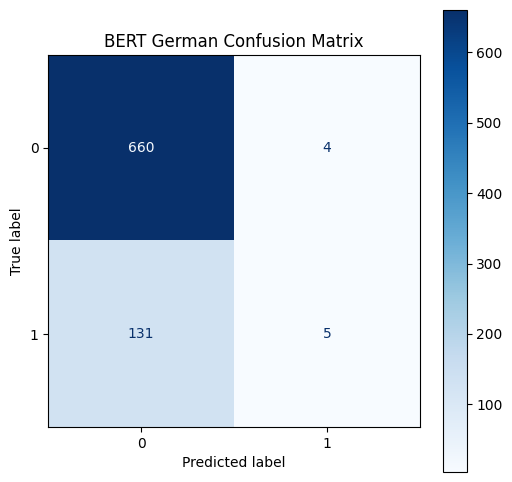

In [23]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("BERT German Confusion Matrix")
plt.show()

### DistilBERT

In [24]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch
from torch.utils.data import Dataset

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

# Training
trainer.train()

# Save Model
model.save_pretrained('./db_hate_speech_model')
tokenizer.save_pretrained('./db_hate_speech_model')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.319400,0.340903,0.891566,0.000000,0.000000,0.000000
2,0.334200,0.325005,0.891566,0.000000,0.000000,0.000000
3,0.288300,0.302160,0.892905,0.529412,0.111111,0.183673


{'eval_loss': 0.30215975642204285, 'eval_accuracy': 0.892904953145917, 'eval_precision': 0.5294117647058824, 'eval_recall': 0.1111111111111111, 'eval_f1': 0.1836734693877551, 'eval_runtime': 1.7606, 'eval_samples_per_second': 424.278, 'eval_steps_per_second': 3.408, 'epoch': 3.0}


Test Results: {'eval_loss': 0.46521490812301636, 'eval_accuracy': 0.825, 'eval_precision': 0.16666666666666666, 'eval_recall': 0.007352941176470588, 'eval_f1': 0.014084507042253521, 'eval_runtime': 1.837, 'eval_samples_per_second': 435.503, 'eval_steps_per_second': 3.811, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.83      0.99      0.90       664
    Hate Speech       0.17      0.01      0.01       136

       accuracy                           0.82       800
      macro avg       0.50      0.50      0.46       800
   weighted avg       0.72      0.82      0.75       800



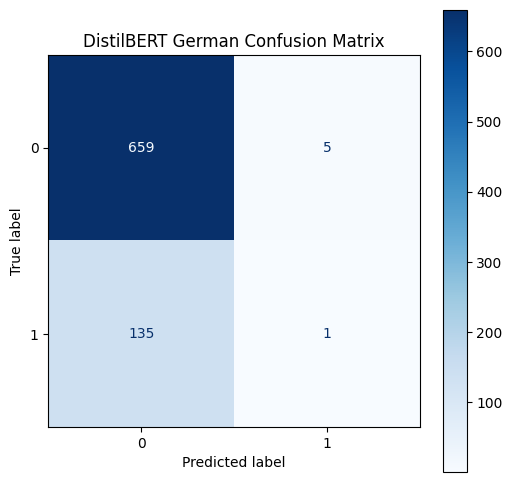

In [25]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("DistilBERT German Confusion Matrix")
plt.show()

### German Bert

In [26]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("TUM/GottBERT_base_last")
model = AutoModelForSequenceClassification.from_pretrained("TUM/GottBERT_base_last", num_labels=2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 4. Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/994k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/536k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/507M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at TUM/GottBERT_base_last and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

In [28]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.323800,0.350709,0.891566,0.000000,0.000000,0.000000
2,0.317100,0.315863,0.894244,1.000000,0.024691,0.048193
3,0.301300,0.277261,0.902276,0.653846,0.209877,0.317757


TrainOutput(global_step=282, training_loss=0.3535204634387442, metrics={'train_runtime': 160.0648, 'train_samples_per_second': 55.946, 'train_steps_per_second': 1.762, 'total_flos': 589039875187200.0, 'train_loss': 0.3535204634387442, 'epoch': 3.0})

In [29]:
# Save Model
model.save_pretrained('./german_bert_hate_speech_model')
tokenizer.save_pretrained('./german_bert_hate_speech_model')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.2772606611251831, 'eval_accuracy': 0.9022757697456493, 'eval_precision': 0.6538461538461539, 'eval_recall': 0.20987654320987653, 'eval_f1': 0.31775700934579443, 'eval_runtime': 2.9898, 'eval_samples_per_second': 249.848, 'eval_steps_per_second': 2.007, 'epoch': 3.0}


Test Results: {'eval_loss': 0.43501341342926025, 'eval_accuracy': 0.82875, 'eval_precision': 0.46153846153846156, 'eval_recall': 0.04411764705882353, 'eval_f1': 0.08053691275167787, 'eval_runtime': 3.2064, 'eval_samples_per_second': 249.497, 'eval_steps_per_second': 2.183, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.83      0.99      0.91       664
    Hate Speech       0.46      0.04      0.08       136

       accuracy                           0.83       800
      macro avg       0.65      0.52      0.49       800
   weighted avg       0.77      0.83      0.77       800



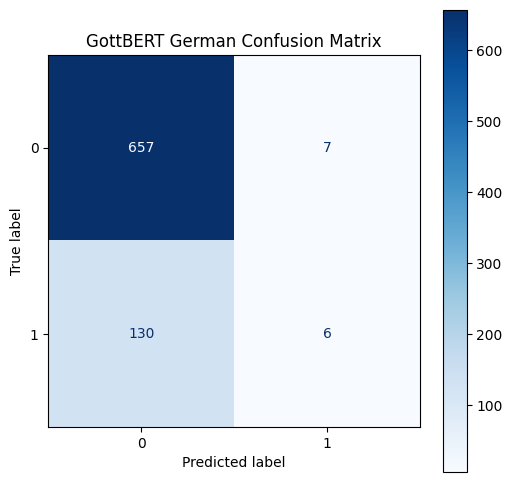

In [30]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("GottBERT German Confusion Matrix")
plt.show()
